# Distribución óptima de dispositivos de feromonas en plantaciones

El objetivo es definir un algoritmo para optimizar la distribución de dispositivos en una plantación, de manera que se se minimice la cantidad de dispositivos sujeto a una restricción, y que éstos se distribuyan de manera uniforme en la plantación.

- El problema corresponde en definir _hileras_ de dispositivos en una hectárea con $p$ plantas, de manera que se minimice la cantidad de dispositivos instalados $d$, sujeto a una restricción de densidad mínima por hectárea $d_{\min} \in \{200, 300, 500\}$. Se asume que $p \geq d_{\min}$.
- Se requiere que los dispositivos estén distribuidos de manera uniforme en la hectárea. Sin embargo, no se requiere que la distribución sea estrictamente regular, y se prefieren patrones "simples" (ver más abajo), lo que motiva el uso de _hileras_ (ver a continuación).

Complementario a las definiciones estrictas del problema, se definen las siguientes restricciones operacionales para la implementación práctica de una solución.

- Se requiere que los patrones definidos en $H_i$ sean "simples". La operacionalización de esta restricción se define a continuación.
- Es preferible minimizar la cardinalidad de $\mathcal{H}$, es decir, la cantidad $n$ de hileras definidas. Esto es, se prefiere un patrón de instalación con pocas hileras, que uno con muchas hileras.
- En términos operacionales, se requiere que la cantidad $k$ de dispositivos instalados no supere en 10\% la densidad mínima.

### Caracterización de una solución

Una **solución** del problema es un vector $R \in P^n$, de forma que $R = (r_1, \ldots, r_n)$, donde $n$ representa la cantidad de hileras definidas.
Cada elemento $r_i \in P$ es una fracción que representa el **ratio** de la hilera $i$, que indica el número de dispositivos sobre el total de plantas.
Por ejemplo, si $r_i = 2/3$ entonces esto indica que en la hilera $i$ deben instalarse 2 dispositivos cada 3 plantas, y si $r_i = 1/4$ entonces deben instalarse 1 dispositivo cada 4 plantas, etc.

El conjunto $P$ de posibles ratios es

$$ P = \left\{ 1, \frac{4}{5}, \frac{2}{3}, \frac{3}{5}, \frac{1}{2}, \frac{1}{3}, \frac{1}{4}, \frac{1}{5} \right\} $$

La definición de los valores en $P$ está motivada por la necesidad de que los patrones de instalación sean "simples". 

De esta forma, una solución $R$ define una distribución de dispositivos en la plantación. Por ejemplo, si $R = (2/3, 1/4)$ entonces esto indica que se debe instalar 2 dispositivios cada 3 plantas en la primera hilera, y luego 1 dispositivo cada 4 plantas en la segunda hilera. Este patrón se repite hasta completar la plantación.

### Espacio de soluciones

Dado un número de hileras $n$, podemos generar todas las combinaciones de largo $n$ de elementos de $P$, es decir, todas las posibles soluciones de $n$ hileras.
El número de estas soluciones es
$$
\frac{(\#P+n-1)!}{n!(\#P-1)!}
$$

Fijando un número máximo de hileras $n_{\max}$, podemos generar todas las posibles soluciones de $1$ a $n_{\max}$ hileras.
El número total de de soluciones en este conjunto es
$$
k = \sum_{n=1}^{n_{\max}}\frac{(\#P+n-1)!}{n!(\#P-1)!}
$$

Entonces, el **espacio de soluciones** $\mathcal{R} = \{ R_1, \ldots, R_k \}$ es el conjunto de todas las posibles soluciones de $1$ a $n_{\max}$ hileras, dado $P$ y $n_{\max}$. En Python, generamos el espacio de soluciones con el siguiente código.

```python
def gen_solution_space(P, n_max):
    """Generate solution space with all possible combinations of patterns.
    This function is completely independent of the problem, and just depends on two user-defined parameters: 
    `n_max` (maximum number of patterns) and `P` (list of possible patterns)."""                
    def generate_combinations(elements, n):
        combinations = []
        for r in range(1, n+1):
            combinations.extend(combinations_with_replacement(elements, r))
        return combinations
    
    all_R = generate_combinations(P, n_max)
    return all_R
```


En particular, para $\#P=8$ (como definimos arriba) y fijando $n_{\max}=4$ hileras, el espacio de soluciones tiene 494 soluciones. Este hecho es uno de los que motiva el uso de un algoritmo de optimización de fuerza bruta para encontrar soluciones óptimas.

In [ ]:
### Compute cardinality of solution space

import math
# Define the values for #R and n_max
n_max = 4  # For example
len_R = 8  # For example
# Calculate the sum
s = 0
for n in range(1, n_max + 1):
    s += math.factorial(len_R + n - 1) / (math.factorial(n) * math.factorial(len_R - 1))

print(s)

494.0



### Evaluación de una solución

Habiendo definido un espacio de soluciones, nos interesa ahora definir un criterio para evaluar una solución $R_j \in \mathcal{R}$.
Dada la naturaleza del problema, son de interés dos variables:
1. la cantidad $n$ de hileras utilizadas, y
2. la cantidad $d$ de dispositivos instalados.

Nos interesa minimizar $n$ porque un menor número de hileras implica un conjunto de instrucciones más simple para llevar a cabo la instalación de dispositivos. Calcular $n_j$ para un $R_j$ dado es trivial.

En segundo lugar, nos interesa también minimizar $d$ porque un menor número de dispositivos implica un menor costo de instalación. Sin embargo, el problema requiere respetar una densidad mínima $d_{\min}$, de forma que $d \geq d_{\min}$.
Dada una solución $R_j$, la cantidad $d_j(R_j; p)$ de dispositivos instalados puede aproximarse como

$$
d(R; p) \approx \sum_{i=1}^n \left\lceil r_i \cdot \frac{p}{n} \right\rceil
$$

En Python implementamos la siguiente función para calcular $d$.

```python
def compute_real_density(R, p):
    """Compute the real density of a solution vector R_j \in .

    Args:
        R (tuple): Solution vector.
        p (int): Number of plants.

    Returns:
        d (int): Number of installed devices.
    """            
    n = len(R)
    d = np.sum(np.round(np.array(R)*p/n))
    return d
```

Notar que se usó una función de _redondeo_ en lugar de _techo_ para calcular $d$. Esto es un punto donde podría mejorarse el cálculo real de $d$, tomando en cuenta que 
- el número de dispositivos debe ser entero,
- las hileras no dividen perfectamente el número de plantas,
- la cantidad de hileras a repetir en la plantación real puede no ser divisible por el número de hileras definidos
- la cantidad de plantas por hilera puede no ser uniforme,
- etc.

### Algoritmo de optimización

El problema podría plantearse como un problema de optimización lineal, escribiendo
$$
\min_{R} d(R; p) \quad \text{s.a.} \quad d \geq d_{\min}
$$

Sin embargo, resolver un problema así tiene una serie de dificultades.
Primero, la función objetivo no es lineal y $R$ es un vector cuyos elementos sólo pueden tomar valores discretos. Esto implica que no es posible aplicar métodos de optimización lineal.
Segundo, no nos interesa solamente minimizar $d$, sino que también nos interesa minimizar $n$, y no es trivial definir una función objetivo que combine satisfactoriamente ambas variables.

Es por estas razones que se optó por un algoritmo de optimización de fuerza bruta. El algoritmo consiste en evaluar todas las soluciones $R_j \in \mathcal{R}$ y seleccionar la solución óptima bajo algún criterio que combine $n_j$ y $d_j$.
En particular, se encuentran dos soluciones óptimas:
1. la solución óptima $R^{\dagger}$ que minimiza $n$ y luego $d$, y
2. la solución óptima $R^*$ que minimiza $d$ y luego $n$.

## Uso y evaluación de soluciones

La clase `chalicelib.devices.Pattern` implementa los métodos descritos hasta ahora.
Abajo se muestra un ejemplo de uso para resolver un problema particular donde $p=444$ y $d_{\min}=200$.

In [2]:
from chalicelib.devices import Pattern

pattern = Pattern(p=444, d_min=200, n_max=4, tolerance_factor=1.1)
pattern.find_optimal_solutions(fractions=True)

((204.0, ['2/3', '1/4']), (200.0, ['3/5', '1/2', '1/4']))

Podemos evaluar sistemáticamente las soluciones encontradas por el algoritmo, para verificar que encuentra soluciones razonables para cualquier combinación de $p$ y $d_{\min} \in \{200, 300, 500\}$.

El código para generar soluciones para distintos valores de $d_{\min}$ a lo largo de un rango razonable de valores de $p$ se encuentra a continuación.
De los gráficos resultantes, notamos que el algoritmo encuentra soluciones satisfactorias para cualquier combinación de $p$ y $d_{\min}$.
- Al minimizar densidad, notamos que siempre cumplimos el objetivo de densidad mínima, y ninguna solución supera la mínima por más de 4%. Esto se logra fijando un número máximo de 4 hileras.
- Al minimizar el número de hileras, vemos que más del 95% de las soluciones usa 2 o 1 hilera. Esto se logra fijando una densidad máxima de 10% sobre la densidad mínima.

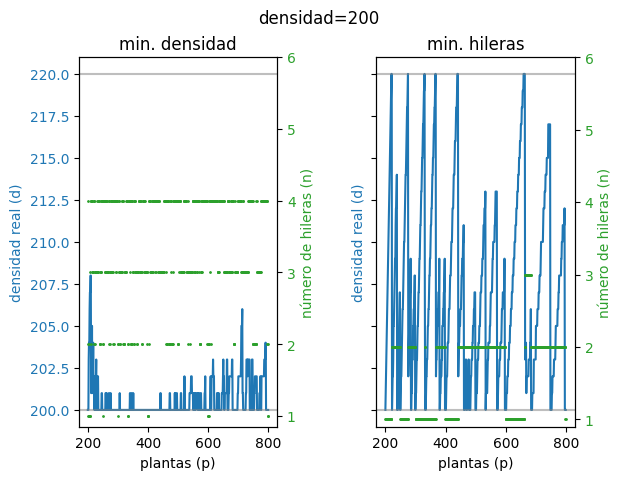

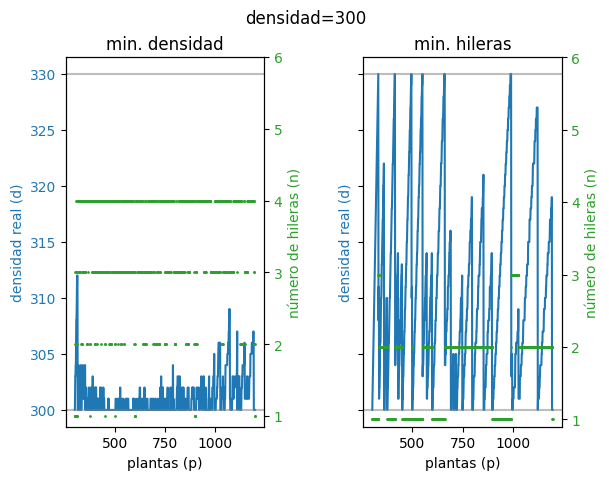

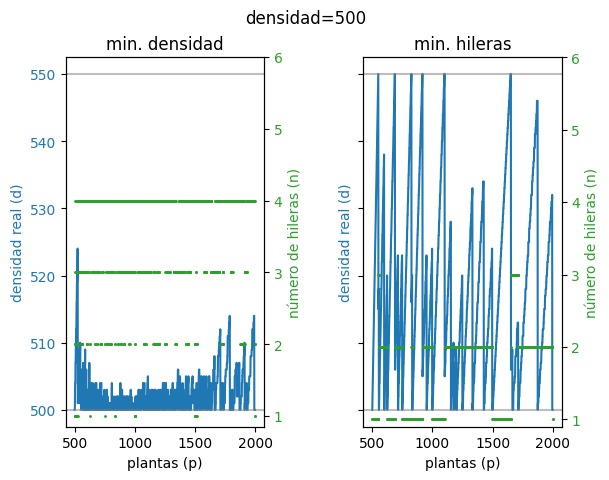

In [1]:
from chalicelib.plots import gen_eval_plot, gen_solutions_linrange
import matplotlib.pyplot as plt

for d_min in [200, 300, 500]:
    X_min_n, X_min_d, P = gen_solutions_linrange(d_min, 4, 1.1, d_min*4)
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.suptitle(f'densidad={d_min}')


    axs[0] = gen_eval_plot(axs[0], P, X_min_d[0], X_min_d[1], d_min, 'min. densidad')
    axs[1] = gen_eval_plot(axs[1], P, X_min_n[0], X_min_n[1], d_min, 'min. hileras')
    plt.subplots_adjust(wspace=.5)